# Rossmann销售预测

## 问题描述

Rossmann在全欧洲有超过6000家药店，预测销售额一直是他们商店经理的工作，他们根据直觉来预测，
准确率有很大变化，现在我们要帮助构建一个销售额预测模型，针对位于德国的1115家店进行6周的销
售额预测，对于销售额的预测可以帮助经理们更合理的安排员工上班时间表、销售活动等。

## 问题链接

https://www.kaggle.com/c/rossmann-store-sales

## 基本流程

1. 开发环境初始化。
2. 加载数据。
3. 拼接数据。
4. 数据预处理。
5. 数据挖掘。
6. 特征工程。
7. 模型构建、训练、调参、融合到一个无法提升的地步。
8. 完善各步骤。
9. 生成kaggle的提交文件。
10. 记录kaggle得分情况。
11. 收获。
12. 引用。

## 环境初始化

In [1]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

## 准备数据

相关数据都存放于当前目录的/data/all中

In [2]:
!ls data/all

sample_submission.csv  store.csv  test.csv  train.csv


### 个别字段含义

    1. Id:测试集内(商店、日期)的组合。
    2. Store:表示每个商店的唯一Id。
    3. Sales:任意一天的销售额，也是我们要预测的字段。
    4. Open:是否开门，0=关门，1=开门。
    5. StateHoliday:国家假日，一般假日国家假期都会关门，所有学校在公共假日都会关门，a=公共假日，b=东部假日，c=圣诞节，0=不是假日。
    6. StoreType:商店类型，有四种，abcd。
    7. Assortment:分类级别，a=基础，b=额外，c=扩展。
    8. CompetitionDistance:竞争对手距离。
    9. CompetitionOpenSince\[Month/Year\]:给出最近竞争对手的开张时间。
    10. Promo:表示商店当天是否进行促销？
    11. Promo2:表示商店是否进行持续的促销活动，0=没有参数，1=参与。
    12. Promo2Since\[Year/Week\]:商店开始持续促销的年/星期。
    13. PromoInterval:持续促销活动开始的间隔，"Feb,May,Aug,Nov"表示给定商店某一年的2589月开始持续促销活动。

### 读取数据

In [194]:
train_data = pd.read_csv('data/all/train.csv')
test_data = pd.read_csv('data/all/test.csv')
store_data = pd.read_csv('data/all/store.csv')

### 字段数据类型转换

In [195]:
train_data.Date = pd.to_datetime(train_data.Date)
test_data.Date = pd.to_datetime(test_data.Date)
store_data['PromoInterval'] = store_data['PromoInterval'].astype(str)

### 浏览下数据

In [196]:
train_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [197]:
test_data.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [198]:
store_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,nan
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,nan


结论：

1. 可以看到train、test和store之间有一个Store字段是相同的，可以同于链接两张表。
2. train中的Store、DayOfWeek、Date、Open、Promo、StateHolidy、SchoolHoliday都不能直接使用，因为不是数值型。
3. store中除COmpetitionDistance外均不能直接使用。

能够看到有大量字段属于枚举型、时间序列，这些字段都要经过处理，否则会影响预测结果。

### 数据的统计值

In [199]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


可以看到，总共有1017209条数据，数据量不算很大，各字段都是完整的，无null字段，这是个好消息，对于train部分不需要做异常数据处理了。

In [200]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.5+ MB


Open字段有11个NaN，这个直接用1，表示开门来填充即可。

In [201]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                1115 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


对于Store数据来说，总共有1115条数据，对应分布于德国的1115间商店，而其中CompetitionOpenSinceMonth、CompetitionOpenSinceYear只有761条数据，也就是说有354个商店没有对应的竞争对手的开张日期字段，而Promo2SinceWeek、Promo2SinceYear、PromoInterval只有571条，也就是说有将近一半的商店是没有持续促销活动的，而还有3个商店没有竞争对手的距离。

In [202]:
store_data[store_data['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,nan
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,nan
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


可以看到有三家店是没有CompetitionDistance，不知道是没有竞争对手还是什么情况，不过既然只有3条，那么直接用平均值填充好了，本身想删掉的，但是考虑到store的信息要链接到train中，这里的3条数据对应train中可就是3\*N条了，因此不删了。

In [203]:
store_data[store_data['CompetitionOpenSinceMonth'].isnull()][:5]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,nan
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


看到对于CompetitionOpenSinceMonth、CompetitionOpenSinceYear的数据，并不是没有竞争对手，只是缺失了对手的开张日期而已，同时缺失了大概1/3的数据，不算很多，那么我们在后面将他们补全吧，补全方式使用其他数据该字段的平均值。

In [204]:
store_data[store_data['Promo2SinceWeek'].isnull()][:5]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,nan
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,nan
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,nan
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,nan


而对于Promo2SinceWeek、Promo2SinceYear、PromoInterval来说，它们并不是缺失，而是当Promo2为0，即没有持续的促销活动时，这三个字段都是NaN，这个是正常的，后面考虑下如何处理Promo2系的字段吧，毕竟缺失较多，或者可以将数据按照是否有Promo2划分开两部分，分别进行训练和预测，恩恩，感觉可以试试看。

## 数据预处理

### Open

In [205]:
test_data.Open.fillna(1, inplace=True)

### CompetitionOpenSinceMonth、CompetitionOpenSinceYear填充

使用该字段不为NaN的字段的数据的median填充，注意要取整。

In [206]:
store_data.CompetitionOpenSinceYear.fillna(store_data.CompetitionOpenSinceYear.median(), inplace=True)
store_data.CompetitionOpenSinceMonth.fillna(store_data.CompetitionOpenSinceMonth.median(), inplace=True)

### CompetitionDistance填充

直接使用该字段不为NaN的median填充。

In [207]:
store_data.CompetitionDistance.fillna(store_data.CompetitionDistance.median(), inplace=True)

## 数据拼接

### Train和Store的链接

根据Store字段将二者链接起来。

In [208]:
train_all = pd.merge(train_data, store_data)
train_all.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
3,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
4,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan


In [209]:
train_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date                         1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHoliday                 1017209 non-null object
SchoolHoliday                1017209 non-null int64
StoreType                    1017209 non-null object
Assortment                   1017209 non-null object
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              509178 non-null float64
Promo2SinceYear              509178 

### Test和Store的链接

同样也将Test和Store链接，方便后续对test进行预测时使用，后续对链接后的处理，同理都要应用到Test+Store的链接数据上。

In [210]:
test_all = pd.merge(test_data, store_data)

In [211]:
test_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 17 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date                         41088 non-null datetime64[ns]
Open                         41088 non-null float64
Promo                        41088 non-null int64
StateHoliday                 41088 non-null object
SchoolHoliday                41088 non-null int64
StoreType                    41088 non-null object
Assortment                   41088 non-null object
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              23856 non-null float64
Promo2SinceYear              23856 non-null float64
PromoInterval                41088 non-null object
dtypes: datetime

### 促销信息缺失

In [212]:
train_all[train_all['Promo2']==0][:3]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
1,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan
2,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,nan


可以看到这部分信息缺失是因为没有参与促销活动。

## 数据挖掘：日期信息、促销信息、竞争对手信息

### 日期信息：提取年、月、日、WeekOfYear（对应Promo2SinceWeek）、是否工作日

对于时间字段，最早我的做法是将其当做枚举来处理，这么做有两个问题：
1. 枚举量很大，影响后续PCA等的效果，实际上如果特征数量有限就不需要PCA了，毕竟PCA算是牺牲了一部分数据表现。
2. 训练数据和测试数据在枚举变量One-Hot后不能对齐。
3. 没有真正对日期信息进行深度的挖掘。

最重要的是时间序列字段对于预测的影响应该是很大的，因为商店的销售应该是具有季节性、日期特殊性的，比如节假日、季节等，因此，通过已有信息挖掘这部分信息出来作为新特征，然后抛弃原有的较原始的信息对于我们的模型来说帮助更大。

提取字段：
1. Year。
2. Quarter。
3. Month。
4. Day。
5. WeekOfYear。
6. IsWorkDay。

In [213]:
def get_datetime_info(data):
    '''
    data:dataFrame
    return year,quarter,month,day,weekOfYear,isWorkDay
    '''
    return (data.Date.apply(lambda date:date.year), 
            data.Date.apply(lambda date:date.quarter), 
            data.Date.apply(lambda date:date.month), 
            data.Date.apply(lambda date:date.day), 
            data.Date.apply(lambda date:date.weekofyear), 
            data.DayOfWeek.apply(lambda dow:dow<=6)) # 周日不上班

In [214]:
get_datetime_info(train_all[:1])

(0    2015
 Name: Date, dtype: int64, 0    3
 Name: Date, dtype: int64, 0    7
 Name: Date, dtype: int64, 0    31
 Name: Date, dtype: int64, 0    31
 Name: Date, dtype: int64, 0    True
 Name: DayOfWeek, dtype: bool)

#### 可视化分析时间字段相对于销售额的影响

In [215]:
train_data.Date.unique()[:30]

array(['2015-07-31T00:00:00.000000000', '2015-07-30T00:00:00.000000000',
       '2015-07-29T00:00:00.000000000', '2015-07-28T00:00:00.000000000',
       '2015-07-27T00:00:00.000000000', '2015-07-26T00:00:00.000000000',
       '2015-07-25T00:00:00.000000000', '2015-07-24T00:00:00.000000000',
       '2015-07-23T00:00:00.000000000', '2015-07-22T00:00:00.000000000',
       '2015-07-21T00:00:00.000000000', '2015-07-20T00:00:00.000000000',
       '2015-07-19T00:00:00.000000000', '2015-07-18T00:00:00.000000000',
       '2015-07-17T00:00:00.000000000', '2015-07-16T00:00:00.000000000',
       '2015-07-15T00:00:00.000000000', '2015-07-14T00:00:00.000000000',
       '2015-07-13T00:00:00.000000000', '2015-07-12T00:00:00.000000000',
       '2015-07-11T00:00:00.000000000', '2015-07-10T00:00:00.000000000',
       '2015-07-09T00:00:00.000000000', '2015-07-08T00:00:00.000000000',
       '2015-07-07T00:00:00.000000000', '2015-07-06T00:00:00.000000000',
       '2015-07-05T00:00:00.000000000', '2015-07-04

日期是连续的，这有助于我们计算一些统计信息。

In [216]:
print '学校放假平均销售额：'+str(train_data[train_data['SchoolHoliday'] == 1].Sales.mean())
print '学校不放假平均销售额：'+str(train_data[train_data['SchoolHoliday'] == 0].Sales.mean())

学校放假平均销售额：6476.52220712
学校不放假平均销售额：5620.97903381


In [217]:
print '国家放假平均销售额：'+str(train_data[train_data['StateHoliday'] != 0].Sales.mean())
print '国家不放假平均销售额：'+str(train_data[train_data['StateHoliday'] == 0].Sales.mean())

国家放假平均销售额：5779.7781799
国家不放假平均销售额：5733.53062439


可以看到仅仅是是否放假，对销售额的影响不大，下面我们看看放假期间的销售额变化。

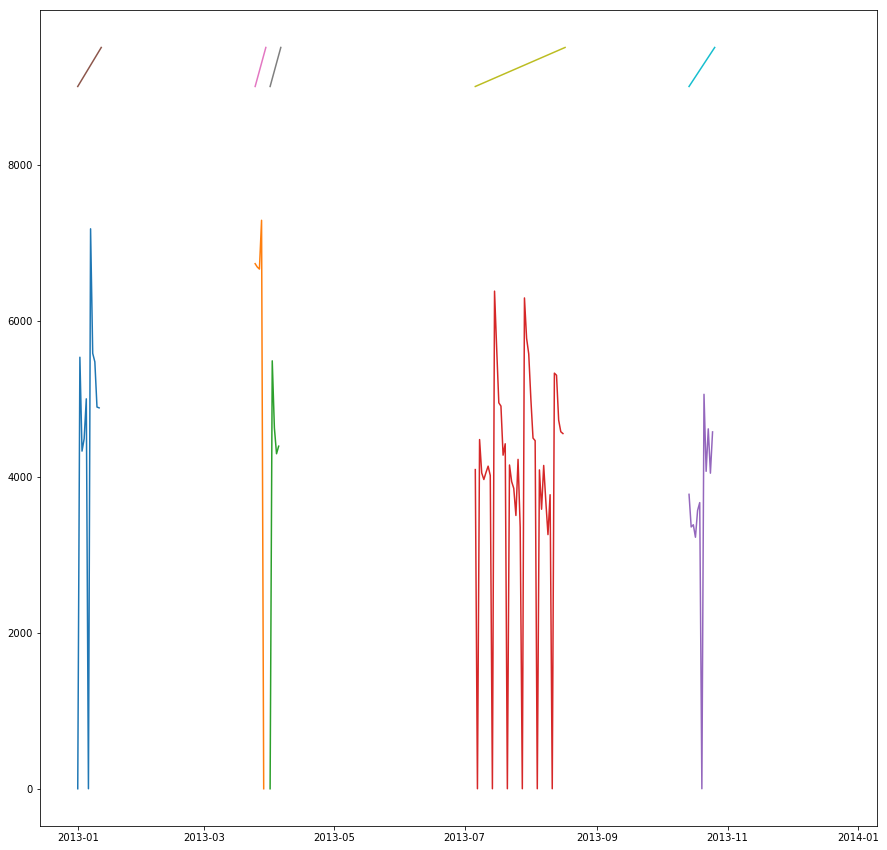

In [218]:
X=[]
Y=[]
X_=[]
Y_=[]
train_data_store1 = train_all[train_all.Store==1][::-1].reset_index()
train_data_store1 = train_data_store1[:360]
holiday_start = False
holiday_end = False
x_temp = []
y_temp = []
plt.figure(figsize=(15,15))
for i in range(len(train_data_store1)):
    d = train_data_store1.loc[i]
    if d.SchoolHoliday==1 and (i==0 or train_data_store1.loc[i-1].SchoolHoliday==0):
        X.append(d.Date)
        Y.append(9000)
        holiday_start = True
        holiday_end = False
        x_temp = []
        y_temp = []
    if d.SchoolHoliday==0 and (i==len(train_data_store1)-1 or train_data_store1.loc[i-1].SchoolHoliday==1):
        X.append(d.Date)
        Y.append(9500)
        holiday_end = True
        holiday_start = False
    if holiday_start and not holiday_end:
        x_temp.append(d.Date)
        y_temp.append(d.Sales)
    if holiday_end and not holiday_start:
        X_.append(x_temp)
        Y_.append(y_temp)
        holiday_end = False

for i in range(len(X_)):
    plt.plot(X_[i], Y_[i])
for i in range(0, min(len(X), len(Y)), 2):
    plt.plot(X[i:i+2], Y[i:i+2])
        

假期的销售额幅度不明显，看来假期对销售额的影响应该不大，至少不是主要的因素。

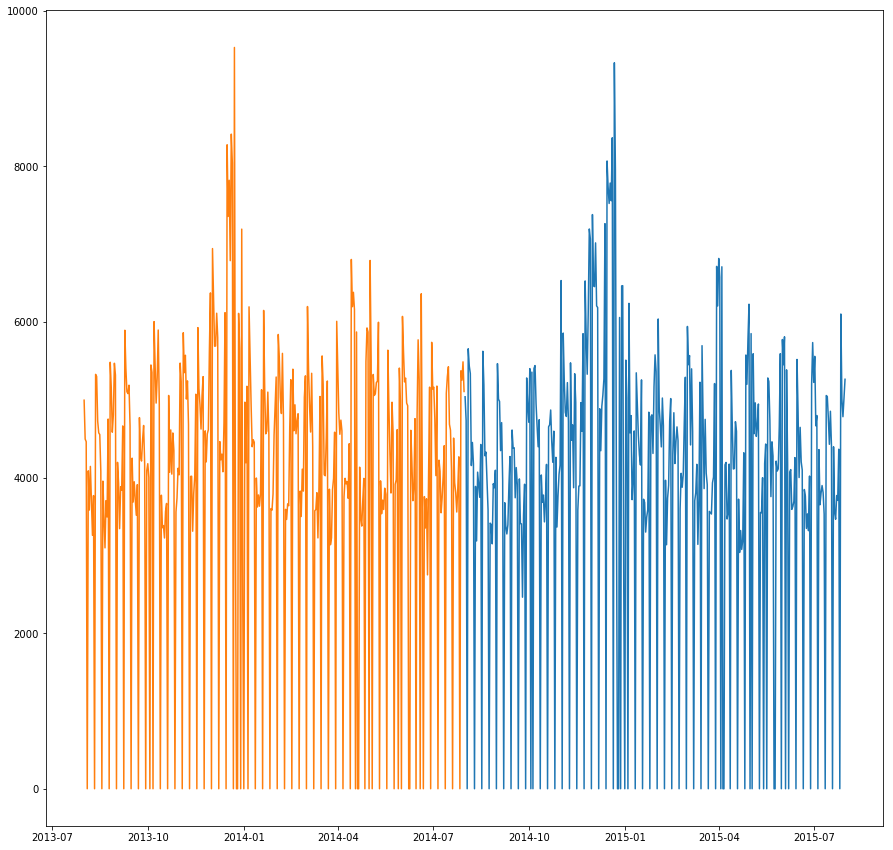

In [219]:
plt.figure(figsize=(15,15))
plt.plot(train_all[train_all.Store==1].Date[:365], train_all[train_all.Store==1].Sales[:365])
plt.plot(train_all[train_all.Store==1].Date[365:365+365], train_all[train_all.Store==1].Sales[365:365+365])

上述图很重要，分别表示了相邻的两年的销售额走势图，我们可以发现，大体上是一致的，这说明一个问题，销售额跟日期息息相关的，也就是说每一年的同一段时期内，可能销售额都会很接近，这就有点像很多行业有他的季节性特点的感觉，这一信息说明具体的日期对预测是至关重要的，因此我们需要提取出具体的年、月、日信息。

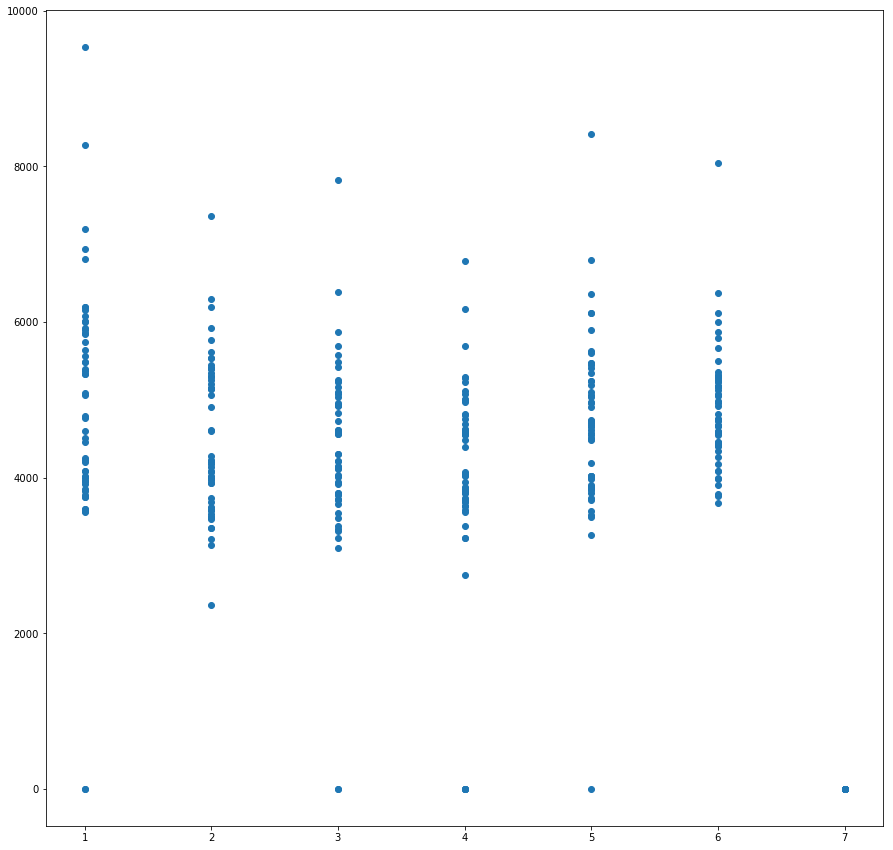

In [220]:
plt.figure(figsize=(15,15))
plt.scatter(train_data[train_data.Store==1].DayOfWeek[365:365+365], train_data[train_data.Store==1].Sales[365:365+365])

In [221]:
print '工作日平均销售额：'+str(train_data[train_data['DayOfWeek'] <=5].Sales.mean())
print '休息日平均销售额：'+str(train_data[train_data['DayOfWeek'] >=6].Sales.mean())

工作日平均销售额：6866.80635082
休息日平均销售额：3025.87289436


可以看到是否是休息日对销售额的影响也是巨大的，这个特征同样重要。

分析一下每一天跟前一个星期、月、季度、半年、一年时间的平均销售额的对比。

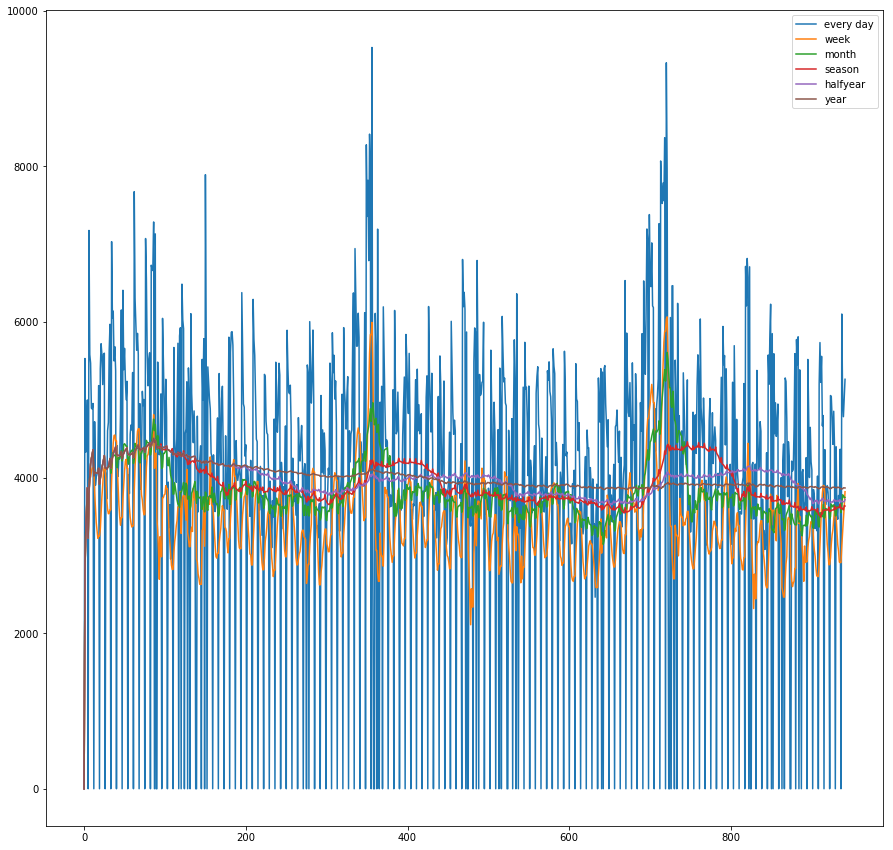

In [222]:
def get_week_month_season_halfyear_year(train_data_store):
    every_day = train_data_store1.Sales
    last_weeks = []
    last_months = []
    last_seasons = []
    last_halfyears = []
    last_years = []
    for i in range(len(every_day)):
        # week
        sales=0
        count=1
        for j in range(i, i-7 if i-7>0 else 0, -1):
            sales+=every_day[j]
            count+=1.
        last_weeks.append(sales/count)
        # month
        sales=0
        count=1
        for j in range(i, i-30 if i-30>0 else 0, -1):
            sales+=every_day[j]
            count+=1.
        last_months.append(sales/count)
        # season
        sales=0
        count=1
        for j in range(i, i-90 if i-90>0 else 0, -1):
            sales+=every_day[j]
            count+=1.
        last_seasons.append(sales/count)
        # halfyear
        sales=0
        count=1
        for j in range(i, i-180 if i-180>0 else 0, -1):
            sales+=every_day[j]
            count+=1.
        last_halfyears.append(sales/count)
        # year
        sales=0
        count=1
        for j in range(i, i-360 if i-360>0 else 0, -1):
            sales+=every_day[j]
            count+=1.
        last_years.append(sales/count)
    return every_day, last_weeks, last_months, last_seasons, last_halfyears, last_years

train_data_store1 = train_all[train_all['Store']==1][::-1].reset_index()
every_day, last_weeks, last_months, last_seasons, last_halfyears, last_years = get_week_month_season_halfyear_year(train_data_store1)
plt.figure(figsize=(15,15))
plt.plot(every_day, label='every day')
plt.plot(last_weeks, label='week')
plt.plot(last_months, label='month')
plt.plot(last_seasons, label='season')
plt.plot(last_halfyears, label='halfyear')
plt.plot(last_years, label='year')
plt.legend()
plt.show()

可以看到趋势方面最接近的应该是week，下面用相关系数确认以下，顺便看一下跟Customers的关系。

In [223]:
pd.DataFrame([last_weeks, last_months, last_seasons, last_halfyears, last_years, 
              list(train_data_store1.Customers)]).corrwith(pd.Series(every_day), axis=1)

0    0.265649
1    0.256849
2    0.124013
3    0.098703
4    0.105531
5    0.984341
dtype: float64

可以看到，就相关性来看，最高的有0.26，也不算很高，暂时不考虑。

### 持续促销活动相关信息挖掘：PromoIntervel、Promo2SinceWeek、Promo2SinceYear

可以开发两个字段：
1. IsInPromo:分别表示当前店铺某天是否处于持续的促销活动中：根据Date、Promo2以及PromoIntervel。
2. PromoDays:促销活动已经持续的时间：根据Date以及Promo2SinceYear、Promo2SinceWeek。

In [224]:
def is_in_promo(data):
    '''
    data:DataFrame。
    return:返回bool值的Seris表示当前是否处于活动中。
    '''
    months_str = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    return data.apply(lambda d:False if d.Promo2==0 else (months_str[int(d.Month-1)] in d.PromoInterval), axis=1)

In [225]:
def get_promo_days(data):
    '''
    return:返回活动已经持续的天数的Series。
    '''
    return data.apply(lambda d:0 if not d.IsInPromo else d.Day, axis=1)

### 竞争对手信息挖掘：CompetitionOpenSinceYear、CompetitionOpenSinceMonth

按照一般的理解上，竞争对手也应该对店铺的销售有很大影响，毕竟同一地区的市场份额是固定的，有一个距离比较近、开张比较久（老字号？）的竞争对手对销售额还是有压力的吧，分析以下。

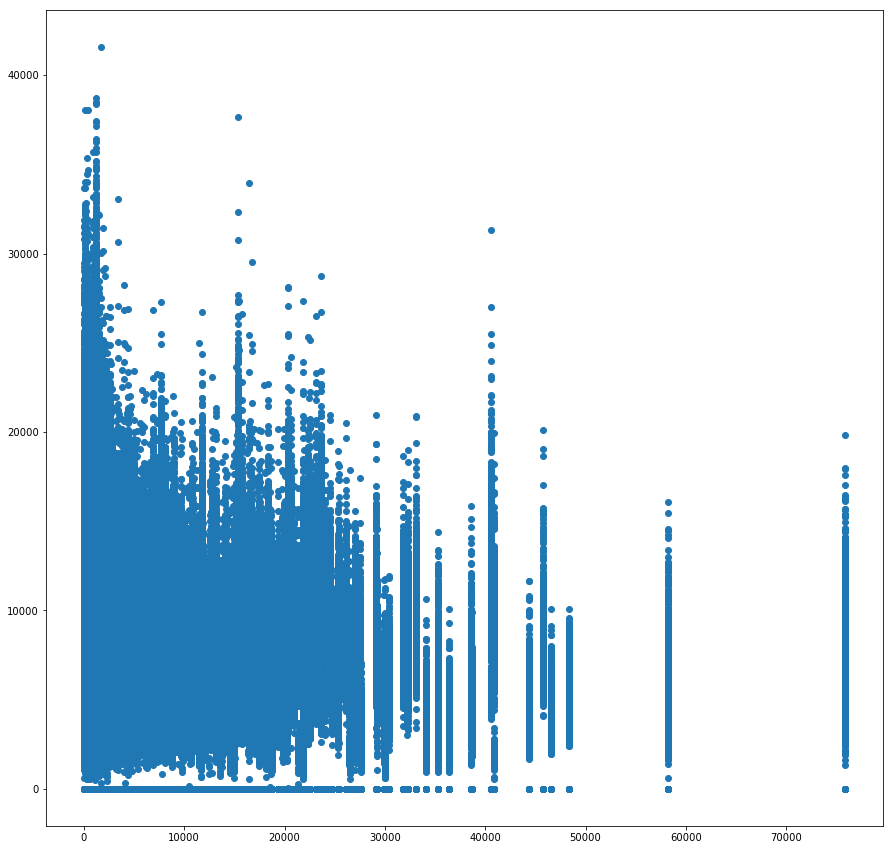

In [226]:
plt.figure(figsize=(15,15))
plt.scatter(train_all.CompetitionDistance, train_all.Sales)

可以看到一个奇怪的现象，似乎与我们的预计不符，并不是竞争对手越远，销售额越高，反而有点相反的意思，这个可能是类似商业圈的特点导致的吧，比如这一代有好几家同样的店，那么大家买这类商品时是不是都倾向于去这些地方买呢，那么就有一种互相促进的感觉，这一点是很有意思的点。

下面再看看跟竞争对手开张时间的关系。

增加字段：
1. CompetitionOpenMonths。

In [227]:
def get_competition_openmonths(data):
    '''
    return:返回截止当前竞争对手的开张时间，月为单位。
    '''
    return data.apply(lambda d:(d.Year-d.CompetitionOpenSinceYear)*12+(d.Month-d.CompetitionOpenSinceMonth), axis=1)

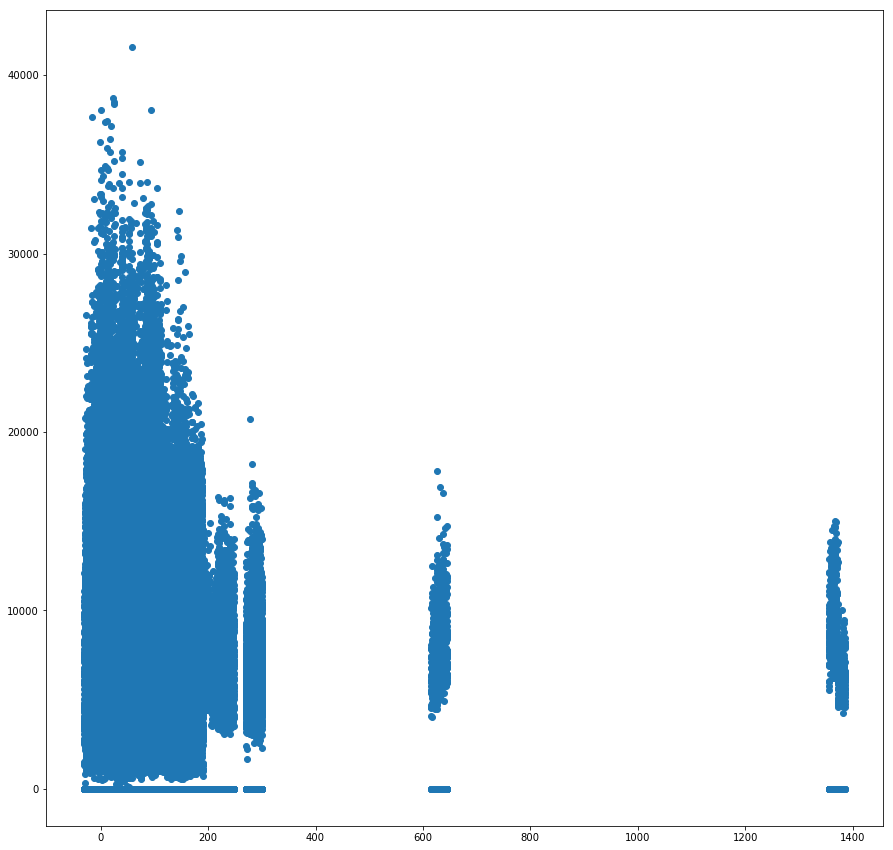

In [228]:
months = train_all.apply(lambda data:(data.Date.year - data.CompetitionOpenSinceYear)*12+(data.Date.month - data.CompetitionOpenSinceMonth), axis=1)
plt.figure(figsize=(15,15))
plt.scatter(months, train_all.Sales)

可以看到，这张图很明显的看到，当对手开张时间比较短时，店铺的销售额比较大，也就是在同一个区域更加受客户欢迎，这个是跟我们的认知一致的信息。

## 特征工程

### 挖掘到的新字段添加

#### Year、Quarter、Month、Day、WeekOfYear、IsWorkDay

In [229]:
train_all['Year'], train_all['Quarter'], train_all['Month'], train_all['Day'], train_all['WeekOfYear'], train_all['IsWorkDay'] = get_datetime_info(train_all)

In [230]:
test_all['Year'], test_all['Quarter'], test_all['Month'], test_all['Day'], test_all['WeekOfYear'], test_all['IsWorkDay'] = get_datetime_info(test_all)

Tips:如果使用train_all.Year增加列，而不是train_all\['Year'\]，后续虽然这个Year可以点出来使用，但是在columns列列表中不存在会有一些问题哦！！！

#### IsInPromo、PromoDays

In [231]:
train_all['IsInPromo'] = is_in_promo(train_all)
train_all.IsInPromo.unique()

array([False,  True], dtype=bool)

In [232]:
test_all['IsInPromo'] = is_in_promo(test_all)

In [233]:
train_all['PromoDays'] = get_promo_days(train_all)
train_all.PromoDays.unique()

array([ 0, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16,
       15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [234]:
test_all['PromoDays'] = get_promo_days(test_all)

#### CompetitionOpenMonths

In [235]:
train_all['CompetitionOpenMonths'] = get_competition_openmonths(train_all)
train_all.CompetitionOpenMonths.unique()[:10]

array([ 82.,  81.,  80.,  79.,  78.,  77.,  76.,  75.,  74.,  73.])

In [236]:
test_all['CompetitionOpenMonths'] = get_competition_openmonths(test_all)

### 无用字段丢弃，注意test.csv是没有Customers数据的哈

Date、Promo2SinceWeek、Promo2SinceYear、PromoInterval、CompetitionOpenSinceMonth、CompetitionOpenSinceYear、Store

In [237]:
drop_cols = ['Date', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval', 
             'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Store']
train_all.drop(drop_cols+['Customers'], axis=1, inplace=True)
test_all.drop(drop_cols, axis=1, inplace=True)

### 当前字段

In [238]:
train_all.columns

Index([u'DayOfWeek', u'Sales', u'Open', u'Promo', u'StateHoliday',
       u'SchoolHoliday', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'Promo2', u'Year', u'Quarter', u'Month', u'Day', u'WeekOfYear',
       u'IsWorkDay', u'IsInPromo', u'PromoDays', u'CompetitionOpenMonths'],
      dtype='object')

In [239]:
test_all.columns

Index([u'Id', u'DayOfWeek', u'Open', u'Promo', u'StateHoliday',
       u'SchoolHoliday', u'StoreType', u'Assortment', u'CompetitionDistance',
       u'Promo2', u'Year', u'Quarter', u'Month', u'Day', u'WeekOfYear',
       u'IsWorkDay', u'IsInPromo', u'PromoDays', u'CompetitionOpenMonths'],
      dtype='object')

### 枚举字段One-Hot编码

当前的枚举字段有：
1. StateHoliday:国家假日，一般假日国家假期都会关门，所有学校在公共假日都会关门，a=公共假日，b=东部假日，c=圣诞节，0=不是假日。
2. StoreType:商店类型，有四种，abcd。
3. Assortment:分类级别，a=基础，b=额外，c=扩展。

在模型中应该是类似节点一样的存在，即作为四个节点将数据导向四个方向，因此将a、b、c、d都映射到1,2,3,4上，不使用OneHot编码，毕竟编码后的维度会增加。

In [240]:
# train_all.head(3)
# train_all = pd.get_dummies(train_all, columns=['StateHoliday', 'StoreType', 'Assortment'])
# train_all.info()
# test_all = pd.get_dummies(test_all, columns=['StateHoliday', 'StoreType', 'Assortment'])
# test_all.info()

In [241]:
code_map = {'a':1, 'b':2, 'c':3, 'd':4, 'e':5, 'f':6, '0':0, 
           1:1, 2:2, 3:3, 4:4, 5:5, 6:6, 0:0}
train_all.StateHoliday = train_all.StateHoliday.map(code_map)
train_all.StoreType = train_all.StoreType.map(code_map)
train_all.Assortment = train_all.Assortment.map(code_map)

test_all.StateHoliday = test_all.StateHoliday.map(code_map)
test_all.StoreType = test_all.StoreType.map(code_map)
test_all.Assortment = test_all.Assortment.map(code_map)

print train_all.StateHoliday.unique()
print test_all.Assortment.unique()

[0 1 2 3]
[1 3 2]


## 数值型数据归一化处理

这主要是避免由数值大小导致的字段在对预测结果的影响中权重不一致，因此做归一化处理，即认为每个字段的影响都是一样的。

数值型字段有：
1. Sales：预测值不用管。
2. CompetitionDistance。
3. PromoDays。
4. CompetitionOpenMonths。

但是有个问题，如果对训练数据、测试数据分别进行了归一化，因为归一化使用的min、max不同，是否对预测有影响不可而知，暂时不进行归一化处理。

### 做归一化之前，我们要先查看下数据中是否有异常值，比如极大极小值等，避免对归一化结果造成影响

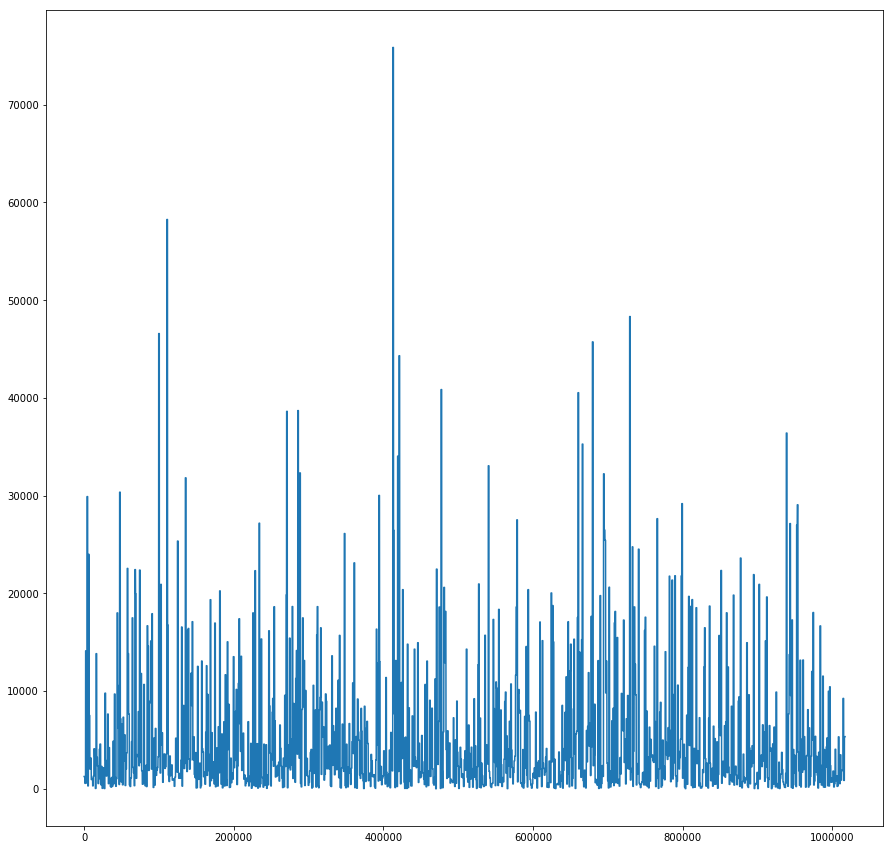

In [52]:
plt.figure(figsize=(15,15))
plt.plot(train_all.CompetitionDistance)

In [53]:
print 'min:'+str(train_all.CompetitionDistance.min())

min:20.0


In [54]:
print 'max:'+str(train_all.CompetitionDistance.max())

max:75860.0


恩恩，也没啥问题，不过这个min为20，这个不会是楼上楼下的关系吧，真的不会打起来么。。。。

### 进行归一化

归一化就使用简单的min-max归一化（是否需要看下数值的分布再决定呢，不是有个归一化算法可以减少值间距导致的差异么），因为现在所有字段都可以理解为数值型，因此直接应用到整个DataFrame上也是可以的，不过为了速度就不这么做了。

In [55]:
# train_all.CompetitionDistance = ((train_all.CompetitionDistance - train_all.CompetitionDistance.min())/(train_all.CompetitionDistance.max() - train_all.CompetitionDistance.min()))
# test_all.CompetitionDistance = ((test_all.CompetitionDistance - test_all.CompetitionDistance.min())/(test_all.CompetitionDistance.max() - test_all.CompetitionDistance.min()))
# print 'min:'+str(train_all.CompetitionDistance.min())
# print 'max:'+str(train_all.CompetitionDistance.max())
# print 'mean:'+str(train_all.CompetitionDistance.mean())

## 将目标字段提取出来

In [56]:
target_all = train_all.Sales
target_all.head(5)

0    5263
1    5020
2    4782
3    5011
4    6102
Name: Sales, dtype: int64

In [57]:
train_all = train_all.drop('Sales', axis=1)
print 'Sales' in train_all.columns

False


可以看到，Sales已经不在训练数据中了。

## 数据集划分

避免每一次模型验证都要上传到kaggle，因此将训练数据划分为训练集和验证集，比例9:1，这样方便自己调试模型，方便起见，这里使用sklearn的cross_validation包的train_test_split方法，该方法实现了随机划分，符合我们要求。

In [159]:
from sklearn.cross_validation import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(train_all, target_all, test_size=0.1)

# y做对数处理
y_train = np.log1p(y_train)
y_valid = np.log1p(y_valid)

print len(x_train)
print len(x_valid)

915488
101721


## 基准模型

基准模型采用恒定猜测为mean值的方式。

先将训练集中Sales的mean值计算出来。

In [162]:
pred_base = np.expm1(y_train).mean()
print '基准模型预测值：'+str(pred_base)

基准模型预测值：5773.45927746


## 性能指标

由于是要提交到kaggle，因此我们选择和kaggle一致的性能指标，即RMSPE。

In [163]:
def rmspe(y_pred, y_real):
    y_pred = list(y_pred)
    y_real = list(y_real)
    for i in range(len(y_real)):
        if y_real[i]==0:
            y_real[i], y_pred[i] = 1., 1.
    return np.sqrt(np.mean((np.divide(np.subtract(y_real, y_pred),y_real))**2))

跟RMSE不同的是引入了/y_i的处理，这样就不会忽略销量很低的情况了。

In [170]:
def rmspe2(y, y_hat):
    return np.sqrt(np.mean((y_hat/y-1.)**2))

In [171]:
def rmspe_xgb(y_hat, y):
    y = np.expm1(y.get_label())
    y_hat = np.expm1(y_hat)
    print y_hat
    print y
    return 'rmspe', rmspe2(y_hat, y)

## 计算基准模型的性能

In [166]:
print '基准模型的RMSPE：'+str(rmspe([pred_base]*len(y_valid), np.expm1(y_valid)))

基准模型的RMSPE：0.439804931616


可以看到是一个很高的误差率了，就是不知道跟我们的模型比较如何。

## 主流程

接下来就是我们的模型相关的流程，之前的数据处理、基准模型构建、基准阈值计算、性能指标函数构建已经完成了，后续主要就是PCA以及模型构建、比较、调试的迭代过程了。

模型选择：本来是选择Adaboost，看中它在小数据集上的表现，但是开题报告的审阅导师推荐了xGBoost，去了解了一下，发现如何区别：
1. adaboost：在优化弱分类器时，依赖的是权重的设置，即加大分类错误的数据的权重，而减小分类正确的数据的权重，使得后续的分类器更关注之前分类错误的点。
2. GBDT：相比较adaboost，区别在于它是通过算梯度来定位模型的不足，因此相比较AdaBoost，它能使用更多的目标函数，比如我们的性能指标函数RMSPE。

而XGBoost是在GBDT的基础上的全方位加强版，具体表现在支持线性分类器、加入了正则项控制模型复杂度、学习速率、速度更快，支持并行等，因此我们的模型优先选择**XGBoost**。

### PCA

进行PCA的目的：
1. 去除数据噪音。
2. 降维，我们的维度高达1000+，以当前数据是不可能描述这么多维度的。
3. 更加了解数据，很多字段我们根本不知道跟目标的关系是什么，pca可以帮助我们梳理这一关系。

第一版的时候由于维度非常多，因此我采用了PCA，主要用于降维，以及特征提取，第二版由于去掉了大部分OneHot部分，因此维度并不是很高，先去掉PCA，毕竟PCA对信息是有损失的。

    from sklearn.decomposition import PCA

    pca = PCA(n_components=10).fit(x_train)
    print pca.explained_variance_ratio_
    print sum(pca.explained_variance_ratio_)

可以看到，效果并不是很理想，前10个新特征总共表现了原来50%的变化，不过也比原来好了很多，先用这个看看。

    x_train_pca = pd.DataFrame(pca.transform(x_train))
    x_valid_pca = pd.DataFrame(pca.transform(x_valid))
    x_train_pca.info()

只剩10个特征了。

### 模型构建

In [167]:
import xgboost as xgb

params = {
    'objective':'reg:linear', 
    'booster':'gbtree', # 注意此处的提升方式，保证了我们之前一些类别字段映射到01234也是可行的，而不需增加维度
    'eta':.03,
    'max_depth':10,
    'subsample':.9,
    'colsample_bytree':.7,
    'silent':1,
    'seed':6
}
num_boost_round = 5000 # 运行次数

train_matrix = xgb.DMatrix(x_train, y_train)
valid_matrix = xgb.DMatrix(x_valid, y_valid)
watchlist = [(train_matrix, 'train'), (valid_matrix, 'valid')]

### 模型训练

In [173]:
print 'XGBoost Model Train Start....'
start_time = time.time()
model = xgb.train(params, train_matrix, num_boost_round, evals=watchlist, 
                  early_stopping_rounds=100)#, feval=rmspe_xgb)
print 'XGBoost Model Train End, Time: {:4f} s....'.format(time.time()-start_time)

XGBoost Model Train Start....
[0]	train-rmse:7.31013	valid-rmse:7.31502
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1]	train-rmse:7.09136	valid-rmse:7.09608
[2]	train-rmse:6.87907	valid-rmse:6.88363
[3]	train-rmse:6.67322	valid-rmse:6.67762
[4]	train-rmse:6.4744	valid-rmse:6.47866
[5]	train-rmse:6.28524	valid-rmse:6.28932
[6]	train-rmse:6.09722	valid-rmse:6.10117
[7]	train-rmse:5.91485	valid-rmse:5.91866
[8]	train-rmse:5.73958	valid-rmse:5.74332
[9]	train-rmse:5.56799	valid-rmse:5.57159
[10]	train-rmse:5.40226	valid-rmse:5.40578
[11]	train-rmse:5.24079	valid-rmse:5.24418
[12]	train-rmse:5.08666	valid-rmse:5.08997
[13]	train-rmse:4.93474	valid-rmse:4.93793
[14]	train-rmse:4.78735	valid-rmse:4.79043
[15]	train-rmse:4.64504	valid-rmse:4.64804
[16]	train-rmse:4.50639	valid-rmse:4.50929
[17]	train-rmse:4.37192	valid-rmse:4.37474
[18]	train-rmse:4.25645	valid-rmse:4.25922
[19]	train-rmse:4.

[181]	train-rmse:0.259127	valid-rmse:0.260005
[182]	train-rmse:0.258899	valid-rmse:0.259778
[183]	train-rmse:0.258326	valid-rmse:0.259199
[184]	train-rmse:0.258011	valid-rmse:0.258888
[185]	train-rmse:0.257619	valid-rmse:0.258489
[186]	train-rmse:0.257109	valid-rmse:0.25797
[187]	train-rmse:0.256762	valid-rmse:0.257627
[188]	train-rmse:0.256319	valid-rmse:0.257179
[189]	train-rmse:0.256041	valid-rmse:0.256906
[190]	train-rmse:0.255815	valid-rmse:0.256681
[191]	train-rmse:0.255302	valid-rmse:0.256185
[192]	train-rmse:0.254934	valid-rmse:0.255818
[193]	train-rmse:0.254799	valid-rmse:0.255688
[194]	train-rmse:0.254622	valid-rmse:0.255509
[195]	train-rmse:0.254488	valid-rmse:0.255368
[196]	train-rmse:0.254344	valid-rmse:0.25523
[197]	train-rmse:0.253899	valid-rmse:0.254781
[198]	train-rmse:0.253516	valid-rmse:0.254391
[199]	train-rmse:0.253288	valid-rmse:0.254169
[200]	train-rmse:0.253146	valid-rmse:0.254027
[201]	train-rmse:0.252694	valid-rmse:0.253571
[202]	train-rmse:0.252564	valid-rmse

[360]	train-rmse:0.210035	valid-rmse:0.212358
[361]	train-rmse:0.209653	valid-rmse:0.211982
[362]	train-rmse:0.209578	valid-rmse:0.211909
[363]	train-rmse:0.208899	valid-rmse:0.211239
[364]	train-rmse:0.208268	valid-rmse:0.21062
[365]	train-rmse:0.207998	valid-rmse:0.210356
[366]	train-rmse:0.207503	valid-rmse:0.209855
[367]	train-rmse:0.207413	valid-rmse:0.209765
[368]	train-rmse:0.207136	valid-rmse:0.209509
[369]	train-rmse:0.207059	valid-rmse:0.209445
[370]	train-rmse:0.206971	valid-rmse:0.209362
[371]	train-rmse:0.206768	valid-rmse:0.209164
[372]	train-rmse:0.206727	valid-rmse:0.209131
[373]	train-rmse:0.206644	valid-rmse:0.209053
[374]	train-rmse:0.206494	valid-rmse:0.20892
[375]	train-rmse:0.206129	valid-rmse:0.208566
[376]	train-rmse:0.20564	valid-rmse:0.208083
[377]	train-rmse:0.205501	valid-rmse:0.207963
[378]	train-rmse:0.205405	valid-rmse:0.207871
[379]	train-rmse:0.205305	valid-rmse:0.207787
[380]	train-rmse:0.204972	valid-rmse:0.207462
[381]	train-rmse:0.204695	valid-rmse:

[539]	train-rmse:0.178361	valid-rmse:0.182604
[540]	train-rmse:0.178216	valid-rmse:0.182461
[541]	train-rmse:0.177898	valid-rmse:0.182167
[542]	train-rmse:0.177647	valid-rmse:0.181925
[543]	train-rmse:0.177617	valid-rmse:0.181899
[544]	train-rmse:0.177554	valid-rmse:0.181851
[545]	train-rmse:0.177428	valid-rmse:0.181729
[546]	train-rmse:0.177262	valid-rmse:0.181579
[547]	train-rmse:0.177159	valid-rmse:0.181503
[548]	train-rmse:0.177125	valid-rmse:0.181483
[549]	train-rmse:0.176965	valid-rmse:0.181327
[550]	train-rmse:0.176898	valid-rmse:0.181262
[551]	train-rmse:0.176809	valid-rmse:0.181182
[552]	train-rmse:0.176535	valid-rmse:0.180929
[553]	train-rmse:0.17639	valid-rmse:0.180795
[554]	train-rmse:0.176161	valid-rmse:0.18059
[555]	train-rmse:0.176125	valid-rmse:0.180554
[556]	train-rmse:0.176022	valid-rmse:0.180454
[557]	train-rmse:0.175986	valid-rmse:0.180434
[558]	train-rmse:0.175792	valid-rmse:0.180271
[559]	train-rmse:0.17566	valid-rmse:0.180151
[560]	train-rmse:0.175639	valid-rmse:

[718]	train-rmse:0.158484	valid-rmse:0.16456
[719]	train-rmse:0.158417	valid-rmse:0.1645
[720]	train-rmse:0.158382	valid-rmse:0.16447
[721]	train-rmse:0.158314	valid-rmse:0.164405
[722]	train-rmse:0.158293	valid-rmse:0.164395
[723]	train-rmse:0.158244	valid-rmse:0.164347
[724]	train-rmse:0.158053	valid-rmse:0.164173
[725]	train-rmse:0.157986	valid-rmse:0.164124
[726]	train-rmse:0.157872	valid-rmse:0.164033
[727]	train-rmse:0.157825	valid-rmse:0.163989
[728]	train-rmse:0.157774	valid-rmse:0.163958
[729]	train-rmse:0.157616	valid-rmse:0.163814
[730]	train-rmse:0.15758	valid-rmse:0.163796
[731]	train-rmse:0.157352	valid-rmse:0.163572
[732]	train-rmse:0.157309	valid-rmse:0.163533
[733]	train-rmse:0.157064	valid-rmse:0.163296
[734]	train-rmse:0.156994	valid-rmse:0.163228
[735]	train-rmse:0.156964	valid-rmse:0.163208
[736]	train-rmse:0.156898	valid-rmse:0.163149
[737]	train-rmse:0.156769	valid-rmse:0.163033
[738]	train-rmse:0.156651	valid-rmse:0.16293
[739]	train-rmse:0.156618	valid-rmse:0.1

[897]	train-rmse:0.14504	valid-rmse:0.152938
[898]	train-rmse:0.144973	valid-rmse:0.152873
[899]	train-rmse:0.144848	valid-rmse:0.15276
[900]	train-rmse:0.144726	valid-rmse:0.152662
[901]	train-rmse:0.144713	valid-rmse:0.152651
[902]	train-rmse:0.144609	valid-rmse:0.15256
[903]	train-rmse:0.144598	valid-rmse:0.15255
[904]	train-rmse:0.144556	valid-rmse:0.152517
[905]	train-rmse:0.144515	valid-rmse:0.152479
[906]	train-rmse:0.144415	valid-rmse:0.152378
[907]	train-rmse:0.144401	valid-rmse:0.152369
[908]	train-rmse:0.144381	valid-rmse:0.152352
[909]	train-rmse:0.144228	valid-rmse:0.152237
[910]	train-rmse:0.144207	valid-rmse:0.15222
[911]	train-rmse:0.144188	valid-rmse:0.152206
[912]	train-rmse:0.144158	valid-rmse:0.152181
[913]	train-rmse:0.144093	valid-rmse:0.152126
[914]	train-rmse:0.144066	valid-rmse:0.152096
[915]	train-rmse:0.144005	valid-rmse:0.152043
[916]	train-rmse:0.143997	valid-rmse:0.15204
[917]	train-rmse:0.143906	valid-rmse:0.151949
[918]	train-rmse:0.143865	valid-rmse:0.1

[1075]	train-rmse:0.134721	valid-rmse:0.144148
[1076]	train-rmse:0.1347	valid-rmse:0.144143
[1077]	train-rmse:0.13467	valid-rmse:0.144137
[1078]	train-rmse:0.134622	valid-rmse:0.144108
[1079]	train-rmse:0.134599	valid-rmse:0.144088
[1080]	train-rmse:0.134484	valid-rmse:0.143981
[1081]	train-rmse:0.13444	valid-rmse:0.143954
[1082]	train-rmse:0.134416	valid-rmse:0.143932
[1083]	train-rmse:0.134333	valid-rmse:0.143857
[1084]	train-rmse:0.13425	valid-rmse:0.143779
[1085]	train-rmse:0.13424	valid-rmse:0.143771
[1086]	train-rmse:0.134199	valid-rmse:0.143744
[1087]	train-rmse:0.134184	valid-rmse:0.143736
[1088]	train-rmse:0.134172	valid-rmse:0.143728
[1089]	train-rmse:0.134117	valid-rmse:0.143677
[1090]	train-rmse:0.134035	valid-rmse:0.143598
[1091]	train-rmse:0.133972	valid-rmse:0.143562
[1092]	train-rmse:0.133966	valid-rmse:0.143556
[1093]	train-rmse:0.133907	valid-rmse:0.143503
[1094]	train-rmse:0.133882	valid-rmse:0.143483
[1095]	train-rmse:0.133772	valid-rmse:0.143387
[1096]	train-rmse:0

[1251]	train-rmse:0.126394	valid-rmse:0.137644
[1252]	train-rmse:0.126388	valid-rmse:0.13764
[1253]	train-rmse:0.126384	valid-rmse:0.137638
[1254]	train-rmse:0.126359	valid-rmse:0.137615
[1255]	train-rmse:0.126342	valid-rmse:0.137602
[1256]	train-rmse:0.126277	valid-rmse:0.137556
[1257]	train-rmse:0.12627	valid-rmse:0.137551
[1258]	train-rmse:0.126258	valid-rmse:0.137547
[1259]	train-rmse:0.126213	valid-rmse:0.137529
[1260]	train-rmse:0.126203	valid-rmse:0.137528
[1261]	train-rmse:0.1262	valid-rmse:0.137537
[1262]	train-rmse:0.12614	valid-rmse:0.137502
[1263]	train-rmse:0.126086	valid-rmse:0.137456
[1264]	train-rmse:0.126041	valid-rmse:0.137424
[1265]	train-rmse:0.126037	valid-rmse:0.137421
[1266]	train-rmse:0.126023	valid-rmse:0.137417
[1267]	train-rmse:0.125998	valid-rmse:0.137397
[1268]	train-rmse:0.125985	valid-rmse:0.137387
[1269]	train-rmse:0.125895	valid-rmse:0.137306
[1270]	train-rmse:0.125888	valid-rmse:0.137301
[1271]	train-rmse:0.125879	valid-rmse:0.137298
[1272]	train-rmse:

[1427]	train-rmse:0.120801	valid-rmse:0.133667
[1428]	train-rmse:0.120797	valid-rmse:0.133664
[1429]	train-rmse:0.120733	valid-rmse:0.133606
[1430]	train-rmse:0.120722	valid-rmse:0.133598
[1431]	train-rmse:0.120664	valid-rmse:0.133562
[1432]	train-rmse:0.120633	valid-rmse:0.133552
[1433]	train-rmse:0.120622	valid-rmse:0.133544
[1434]	train-rmse:0.120607	valid-rmse:0.133539
[1435]	train-rmse:0.120578	valid-rmse:0.133521
[1436]	train-rmse:0.120514	valid-rmse:0.133458
[1437]	train-rmse:0.120501	valid-rmse:0.13345
[1438]	train-rmse:0.120481	valid-rmse:0.133437
[1439]	train-rmse:0.120474	valid-rmse:0.133434
[1440]	train-rmse:0.120402	valid-rmse:0.133393
[1441]	train-rmse:0.120387	valid-rmse:0.133387
[1442]	train-rmse:0.12037	valid-rmse:0.133381
[1443]	train-rmse:0.120361	valid-rmse:0.133374
[1444]	train-rmse:0.120354	valid-rmse:0.133372
[1445]	train-rmse:0.120307	valid-rmse:0.133332
[1446]	train-rmse:0.120286	valid-rmse:0.133314
[1447]	train-rmse:0.120256	valid-rmse:0.133296
[1448]	train-rm

[1603]	train-rmse:0.115189	valid-rmse:0.129664
[1604]	train-rmse:0.115134	valid-rmse:0.129622
[1605]	train-rmse:0.115102	valid-rmse:0.129593
[1606]	train-rmse:0.115094	valid-rmse:0.129588
[1607]	train-rmse:0.115074	valid-rmse:0.12958
[1608]	train-rmse:0.115062	valid-rmse:0.129572
[1609]	train-rmse:0.115053	valid-rmse:0.129571
[1610]	train-rmse:0.115036	valid-rmse:0.12957
[1611]	train-rmse:0.114981	valid-rmse:0.129526
[1612]	train-rmse:0.114978	valid-rmse:0.129523
[1613]	train-rmse:0.114943	valid-rmse:0.129504
[1614]	train-rmse:0.114913	valid-rmse:0.12943
[1615]	train-rmse:0.114909	valid-rmse:0.129428
[1616]	train-rmse:0.114903	valid-rmse:0.129426
[1617]	train-rmse:0.114889	valid-rmse:0.129418
[1618]	train-rmse:0.114883	valid-rmse:0.129414
[1619]	train-rmse:0.114857	valid-rmse:0.129401
[1620]	train-rmse:0.11485	valid-rmse:0.129398
[1621]	train-rmse:0.114823	valid-rmse:0.129377
[1622]	train-rmse:0.11482	valid-rmse:0.129373
[1623]	train-rmse:0.1148	valid-rmse:0.129358
[1624]	train-rmse:0.

[1779]	train-rmse:0.111256	valid-rmse:0.127171
[1780]	train-rmse:0.111217	valid-rmse:0.127139
[1781]	train-rmse:0.111184	valid-rmse:0.127118
[1782]	train-rmse:0.111179	valid-rmse:0.127123
[1783]	train-rmse:0.111159	valid-rmse:0.127115
[1784]	train-rmse:0.111155	valid-rmse:0.127113
[1785]	train-rmse:0.111146	valid-rmse:0.127108
[1786]	train-rmse:0.111124	valid-rmse:0.1271
[1787]	train-rmse:0.111119	valid-rmse:0.127098
[1788]	train-rmse:0.111085	valid-rmse:0.127069
[1789]	train-rmse:0.111048	valid-rmse:0.127043
[1790]	train-rmse:0.111039	valid-rmse:0.127034
[1791]	train-rmse:0.111036	valid-rmse:0.127033
[1792]	train-rmse:0.110966	valid-rmse:0.126984
[1793]	train-rmse:0.110955	valid-rmse:0.126981
[1794]	train-rmse:0.110936	valid-rmse:0.126967
[1795]	train-rmse:0.110934	valid-rmse:0.126966
[1796]	train-rmse:0.110931	valid-rmse:0.126964
[1797]	train-rmse:0.110921	valid-rmse:0.126956
[1798]	train-rmse:0.110901	valid-rmse:0.126945
[1799]	train-rmse:0.110889	valid-rmse:0.126937
[1800]	train-rm

[1955]	train-rmse:0.107298	valid-rmse:0.124766
[1956]	train-rmse:0.107241	valid-rmse:0.124718
[1957]	train-rmse:0.107225	valid-rmse:0.124709
[1958]	train-rmse:0.107203	valid-rmse:0.124692
[1959]	train-rmse:0.107191	valid-rmse:0.124691
[1960]	train-rmse:0.107186	valid-rmse:0.124688
[1961]	train-rmse:0.107179	valid-rmse:0.124685
[1962]	train-rmse:0.107163	valid-rmse:0.124673
[1963]	train-rmse:0.107149	valid-rmse:0.124663
[1964]	train-rmse:0.107144	valid-rmse:0.124661
[1965]	train-rmse:0.107087	valid-rmse:0.124609
[1966]	train-rmse:0.107083	valid-rmse:0.124607
[1967]	train-rmse:0.107069	valid-rmse:0.124597
[1968]	train-rmse:0.107043	valid-rmse:0.124576
[1969]	train-rmse:0.10699	valid-rmse:0.124529
[1970]	train-rmse:0.106982	valid-rmse:0.124525
[1971]	train-rmse:0.106949	valid-rmse:0.124502
[1972]	train-rmse:0.106902	valid-rmse:0.124466
[1973]	train-rmse:0.106892	valid-rmse:0.124461
[1974]	train-rmse:0.106883	valid-rmse:0.124455
[1975]	train-rmse:0.106877	valid-rmse:0.124451
[1976]	train-r

[2130]	train-rmse:0.103005	valid-rmse:0.122251
[2131]	train-rmse:0.102986	valid-rmse:0.122239
[2132]	train-rmse:0.102973	valid-rmse:0.122237
[2133]	train-rmse:0.102956	valid-rmse:0.122234
[2134]	train-rmse:0.10293	valid-rmse:0.122217
[2135]	train-rmse:0.102905	valid-rmse:0.122203
[2136]	train-rmse:0.102894	valid-rmse:0.122199
[2137]	train-rmse:0.10289	valid-rmse:0.122197
[2138]	train-rmse:0.102871	valid-rmse:0.1222
[2139]	train-rmse:0.102854	valid-rmse:0.122186
[2140]	train-rmse:0.102852	valid-rmse:0.122186
[2141]	train-rmse:0.10284	valid-rmse:0.122179
[2142]	train-rmse:0.102808	valid-rmse:0.122164
[2143]	train-rmse:0.102791	valid-rmse:0.12213
[2144]	train-rmse:0.102748	valid-rmse:0.122094
[2145]	train-rmse:0.102727	valid-rmse:0.122084
[2146]	train-rmse:0.102712	valid-rmse:0.122074
[2147]	train-rmse:0.1027	valid-rmse:0.122066
[2148]	train-rmse:0.102696	valid-rmse:0.122064
[2149]	train-rmse:0.102689	valid-rmse:0.122062
[2150]	train-rmse:0.102632	valid-rmse:0.12203
[2151]	train-rmse:0.10

[2306]	train-rmse:0.099828	valid-rmse:0.120566
[2307]	train-rmse:0.099788	valid-rmse:0.120541
[2308]	train-rmse:0.099773	valid-rmse:0.120532
[2309]	train-rmse:0.099751	valid-rmse:0.120517
[2310]	train-rmse:0.099734	valid-rmse:0.12051
[2311]	train-rmse:0.099717	valid-rmse:0.120502
[2312]	train-rmse:0.099696	valid-rmse:0.120495
[2313]	train-rmse:0.099692	valid-rmse:0.120493
[2314]	train-rmse:0.099674	valid-rmse:0.120481
[2315]	train-rmse:0.099663	valid-rmse:0.120471
[2316]	train-rmse:0.099658	valid-rmse:0.120469
[2317]	train-rmse:0.09965	valid-rmse:0.120463
[2318]	train-rmse:0.099646	valid-rmse:0.120461
[2319]	train-rmse:0.099623	valid-rmse:0.120444
[2320]	train-rmse:0.099602	valid-rmse:0.120429
[2321]	train-rmse:0.099586	valid-rmse:0.120428
[2322]	train-rmse:0.099575	valid-rmse:0.120425
[2323]	train-rmse:0.099563	valid-rmse:0.120421
[2324]	train-rmse:0.099544	valid-rmse:0.120407
[2325]	train-rmse:0.09954	valid-rmse:0.120403
[2326]	train-rmse:0.099537	valid-rmse:0.120402
[2327]	train-rms

[2482]	train-rmse:0.096854	valid-rmse:0.118906
[2483]	train-rmse:0.09683	valid-rmse:0.118888
[2484]	train-rmse:0.096826	valid-rmse:0.118886
[2485]	train-rmse:0.096814	valid-rmse:0.118881
[2486]	train-rmse:0.096797	valid-rmse:0.11887
[2487]	train-rmse:0.096791	valid-rmse:0.118866
[2488]	train-rmse:0.096784	valid-rmse:0.118864
[2489]	train-rmse:0.096769	valid-rmse:0.118856
[2490]	train-rmse:0.096754	valid-rmse:0.11885
[2491]	train-rmse:0.096751	valid-rmse:0.118848
[2492]	train-rmse:0.09673	valid-rmse:0.118817
[2493]	train-rmse:0.096718	valid-rmse:0.118809
[2494]	train-rmse:0.096683	valid-rmse:0.118786
[2495]	train-rmse:0.096672	valid-rmse:0.118784
[2496]	train-rmse:0.096655	valid-rmse:0.118783
[2497]	train-rmse:0.09663	valid-rmse:0.118769
[2498]	train-rmse:0.096598	valid-rmse:0.118717
[2499]	train-rmse:0.096584	valid-rmse:0.118714
[2500]	train-rmse:0.096575	valid-rmse:0.118713
[2501]	train-rmse:0.096567	valid-rmse:0.118711
[2502]	train-rmse:0.096549	valid-rmse:0.118704
[2503]	train-rmse:

[2658]	train-rmse:0.094405	valid-rmse:0.11768
[2659]	train-rmse:0.09439	valid-rmse:0.117671
[2660]	train-rmse:0.094386	valid-rmse:0.117668
[2661]	train-rmse:0.09438	valid-rmse:0.117667
[2662]	train-rmse:0.094361	valid-rmse:0.117665
[2663]	train-rmse:0.094328	valid-rmse:0.117649
[2664]	train-rmse:0.094311	valid-rmse:0.117645
[2665]	train-rmse:0.094294	valid-rmse:0.117635
[2666]	train-rmse:0.094287	valid-rmse:0.117632
[2667]	train-rmse:0.094272	valid-rmse:0.11763
[2668]	train-rmse:0.09426	valid-rmse:0.117631
[2669]	train-rmse:0.094245	valid-rmse:0.117625
[2670]	train-rmse:0.094242	valid-rmse:0.117623
[2671]	train-rmse:0.094239	valid-rmse:0.117622
[2672]	train-rmse:0.094224	valid-rmse:0.117622
[2673]	train-rmse:0.094217	valid-rmse:0.117622
[2674]	train-rmse:0.094191	valid-rmse:0.117602
[2675]	train-rmse:0.094186	valid-rmse:0.1176
[2676]	train-rmse:0.09417	valid-rmse:0.117594
[2677]	train-rmse:0.094168	valid-rmse:0.117592
[2678]	train-rmse:0.094134	valid-rmse:0.117559
[2679]	train-rmse:0.0

[2834]	train-rmse:0.092084	valid-rmse:0.116654
[2835]	train-rmse:0.092052	valid-rmse:0.11664
[2836]	train-rmse:0.092049	valid-rmse:0.116639
[2837]	train-rmse:0.092026	valid-rmse:0.116631
[2838]	train-rmse:0.091994	valid-rmse:0.116628
[2839]	train-rmse:0.091988	valid-rmse:0.116637
[2840]	train-rmse:0.091983	valid-rmse:0.116634
[2841]	train-rmse:0.091971	valid-rmse:0.116629
[2842]	train-rmse:0.091963	valid-rmse:0.116625
[2843]	train-rmse:0.09196	valid-rmse:0.116624
[2844]	train-rmse:0.091954	valid-rmse:0.116621
[2845]	train-rmse:0.091936	valid-rmse:0.116612
[2846]	train-rmse:0.091913	valid-rmse:0.116595
[2847]	train-rmse:0.091903	valid-rmse:0.116591
[2848]	train-rmse:0.091899	valid-rmse:0.116588
[2849]	train-rmse:0.091888	valid-rmse:0.116587
[2850]	train-rmse:0.091887	valid-rmse:0.116587
[2851]	train-rmse:0.091866	valid-rmse:0.116585
[2852]	train-rmse:0.091837	valid-rmse:0.116575
[2853]	train-rmse:0.091832	valid-rmse:0.116573
[2854]	train-rmse:0.091825	valid-rmse:0.116572
[2855]	train-rm

[3010]	train-rmse:0.089804	valid-rmse:0.115752
[3011]	train-rmse:0.089798	valid-rmse:0.11575
[3012]	train-rmse:0.089793	valid-rmse:0.115749
[3013]	train-rmse:0.089781	valid-rmse:0.115747
[3014]	train-rmse:0.089771	valid-rmse:0.115741
[3015]	train-rmse:0.089761	valid-rmse:0.115737
[3016]	train-rmse:0.089746	valid-rmse:0.115733
[3017]	train-rmse:0.08974	valid-rmse:0.11573
[3018]	train-rmse:0.089739	valid-rmse:0.115729
[3019]	train-rmse:0.089721	valid-rmse:0.115719
[3020]	train-rmse:0.089697	valid-rmse:0.115707
[3021]	train-rmse:0.08969	valid-rmse:0.115705
[3022]	train-rmse:0.089683	valid-rmse:0.115708
[3023]	train-rmse:0.089667	valid-rmse:0.115698
[3024]	train-rmse:0.089658	valid-rmse:0.115692
[3025]	train-rmse:0.089636	valid-rmse:0.115685
[3026]	train-rmse:0.089626	valid-rmse:0.115683
[3027]	train-rmse:0.089617	valid-rmse:0.115685
[3028]	train-rmse:0.089613	valid-rmse:0.115685
[3029]	train-rmse:0.089601	valid-rmse:0.115682
[3030]	train-rmse:0.089593	valid-rmse:0.115682
[3031]	train-rmse

[3186]	train-rmse:0.087818	valid-rmse:0.115105
[3187]	train-rmse:0.087796	valid-rmse:0.115111
[3188]	train-rmse:0.087788	valid-rmse:0.11511
[3189]	train-rmse:0.087778	valid-rmse:0.115107
[3190]	train-rmse:0.087765	valid-rmse:0.115109
[3191]	train-rmse:0.087748	valid-rmse:0.115101
[3192]	train-rmse:0.087746	valid-rmse:0.1151
[3193]	train-rmse:0.087738	valid-rmse:0.115097
[3194]	train-rmse:0.087731	valid-rmse:0.115095
[3195]	train-rmse:0.087718	valid-rmse:0.115087
[3196]	train-rmse:0.087716	valid-rmse:0.115086
[3197]	train-rmse:0.087708	valid-rmse:0.115085
[3198]	train-rmse:0.08769	valid-rmse:0.115075
[3199]	train-rmse:0.087668	valid-rmse:0.11507
[3200]	train-rmse:0.087665	valid-rmse:0.115069
[3201]	train-rmse:0.087651	valid-rmse:0.115067
[3202]	train-rmse:0.087648	valid-rmse:0.115071
[3203]	train-rmse:0.087645	valid-rmse:0.115069
[3204]	train-rmse:0.087623	valid-rmse:0.11506
[3205]	train-rmse:0.087616	valid-rmse:0.115059
[3206]	train-rmse:0.087612	valid-rmse:0.115057
[3207]	train-rmse:0

[3362]	train-rmse:0.086023	valid-rmse:0.114486
[3363]	train-rmse:0.086015	valid-rmse:0.114483
[3364]	train-rmse:0.086	valid-rmse:0.114484
[3365]	train-rmse:0.085975	valid-rmse:0.114465
[3366]	train-rmse:0.085972	valid-rmse:0.114465
[3367]	train-rmse:0.085963	valid-rmse:0.114447
[3368]	train-rmse:0.08595	valid-rmse:0.114443
[3369]	train-rmse:0.085923	valid-rmse:0.114428
[3370]	train-rmse:0.085919	valid-rmse:0.114425
[3371]	train-rmse:0.085902	valid-rmse:0.114423
[3372]	train-rmse:0.085891	valid-rmse:0.114419
[3373]	train-rmse:0.08588	valid-rmse:0.114418
[3374]	train-rmse:0.085877	valid-rmse:0.114419
[3375]	train-rmse:0.085871	valid-rmse:0.114415
[3376]	train-rmse:0.085858	valid-rmse:0.114415
[3377]	train-rmse:0.08585	valid-rmse:0.114418
[3378]	train-rmse:0.085843	valid-rmse:0.114421
[3379]	train-rmse:0.085809	valid-rmse:0.114419
[3380]	train-rmse:0.085802	valid-rmse:0.114419
[3381]	train-rmse:0.085795	valid-rmse:0.114428
[3382]	train-rmse:0.085783	valid-rmse:0.114426
[3383]	train-rmse:0

[3538]	train-rmse:0.084299	valid-rmse:0.114045
[3539]	train-rmse:0.084287	valid-rmse:0.114043
[3540]	train-rmse:0.084277	valid-rmse:0.114046
[3541]	train-rmse:0.084263	valid-rmse:0.114041
[3542]	train-rmse:0.084256	valid-rmse:0.11404
[3543]	train-rmse:0.084252	valid-rmse:0.11404
[3544]	train-rmse:0.084233	valid-rmse:0.114042
[3545]	train-rmse:0.084229	valid-rmse:0.114041
[3546]	train-rmse:0.084213	valid-rmse:0.114036
[3547]	train-rmse:0.084207	valid-rmse:0.114037
[3548]	train-rmse:0.084206	valid-rmse:0.114036
[3549]	train-rmse:0.084203	valid-rmse:0.114036
[3550]	train-rmse:0.084201	valid-rmse:0.114035
[3551]	train-rmse:0.084184	valid-rmse:0.114027
[3552]	train-rmse:0.084179	valid-rmse:0.114025
[3553]	train-rmse:0.084159	valid-rmse:0.114011
[3554]	train-rmse:0.084148	valid-rmse:0.114011
[3555]	train-rmse:0.08414	valid-rmse:0.114011
[3556]	train-rmse:0.084133	valid-rmse:0.114009
[3557]	train-rmse:0.084114	valid-rmse:0.114007
[3558]	train-rmse:0.084099	valid-rmse:0.113999
[3559]	train-rms

[3714]	train-rmse:0.082779	valid-rmse:0.113632
[3715]	train-rmse:0.082764	valid-rmse:0.113631
[3716]	train-rmse:0.082762	valid-rmse:0.11363
[3717]	train-rmse:0.082761	valid-rmse:0.11363
[3718]	train-rmse:0.082752	valid-rmse:0.11363
[3719]	train-rmse:0.082734	valid-rmse:0.113623
[3720]	train-rmse:0.082726	valid-rmse:0.113618
[3721]	train-rmse:0.082724	valid-rmse:0.113617
[3722]	train-rmse:0.082708	valid-rmse:0.113614
[3723]	train-rmse:0.082699	valid-rmse:0.113609
[3724]	train-rmse:0.082691	valid-rmse:0.113611
[3725]	train-rmse:0.082684	valid-rmse:0.113618
[3726]	train-rmse:0.082674	valid-rmse:0.113615
[3727]	train-rmse:0.082666	valid-rmse:0.113613
[3728]	train-rmse:0.082658	valid-rmse:0.113613
[3729]	train-rmse:0.082651	valid-rmse:0.113614
[3730]	train-rmse:0.082636	valid-rmse:0.113609
[3731]	train-rmse:0.082623	valid-rmse:0.113622
[3732]	train-rmse:0.082617	valid-rmse:0.113621
[3733]	train-rmse:0.082592	valid-rmse:0.113614
[3734]	train-rmse:0.082581	valid-rmse:0.113618
[3735]	train-rms

[3889]	train-rmse:0.081356	valid-rmse:0.113368
[3890]	train-rmse:0.081348	valid-rmse:0.11337
[3891]	train-rmse:0.081344	valid-rmse:0.113369
[3892]	train-rmse:0.08133	valid-rmse:0.11336
[3893]	train-rmse:0.081314	valid-rmse:0.113363
[3894]	train-rmse:0.081305	valid-rmse:0.113359
[3895]	train-rmse:0.081298	valid-rmse:0.113362
[3896]	train-rmse:0.08128	valid-rmse:0.113353
[3897]	train-rmse:0.081271	valid-rmse:0.113354
[3898]	train-rmse:0.081262	valid-rmse:0.113355
[3899]	train-rmse:0.081259	valid-rmse:0.113356
[3900]	train-rmse:0.081258	valid-rmse:0.113355
[3901]	train-rmse:0.081251	valid-rmse:0.113354
[3902]	train-rmse:0.081239	valid-rmse:0.11335
[3903]	train-rmse:0.081234	valid-rmse:0.113349
[3904]	train-rmse:0.08123	valid-rmse:0.113349
[3905]	train-rmse:0.081226	valid-rmse:0.113347
[3906]	train-rmse:0.081222	valid-rmse:0.113345
[3907]	train-rmse:0.081212	valid-rmse:0.113344
[3908]	train-rmse:0.08121	valid-rmse:0.113343
[3909]	train-rmse:0.081208	valid-rmse:0.113342
[3910]	train-rmse:0.

[4065]	train-rmse:0.080129	valid-rmse:0.11316
[4066]	train-rmse:0.080111	valid-rmse:0.113158
[4067]	train-rmse:0.080107	valid-rmse:0.113157
[4068]	train-rmse:0.080105	valid-rmse:0.113157
[4069]	train-rmse:0.080103	valid-rmse:0.113156
[4070]	train-rmse:0.080094	valid-rmse:0.113155
[4071]	train-rmse:0.080081	valid-rmse:0.113159
[4072]	train-rmse:0.080067	valid-rmse:0.113145
[4073]	train-rmse:0.080062	valid-rmse:0.113144
[4074]	train-rmse:0.08006	valid-rmse:0.113146
[4075]	train-rmse:0.080057	valid-rmse:0.113147
[4076]	train-rmse:0.080057	valid-rmse:0.113147
[4077]	train-rmse:0.080056	valid-rmse:0.113146
[4078]	train-rmse:0.080052	valid-rmse:0.113146
[4079]	train-rmse:0.080037	valid-rmse:0.113142
[4080]	train-rmse:0.080034	valid-rmse:0.113141
[4081]	train-rmse:0.080032	valid-rmse:0.11314
[4082]	train-rmse:0.080027	valid-rmse:0.113141
[4083]	train-rmse:0.080024	valid-rmse:0.113143
[4084]	train-rmse:0.080015	valid-rmse:0.11314
[4085]	train-rmse:0.080014	valid-rmse:0.11314
[4086]	train-rmse:

[4240]	train-rmse:0.078942	valid-rmse:0.112954
[4241]	train-rmse:0.078938	valid-rmse:0.112958
[4242]	train-rmse:0.07893	valid-rmse:0.112961
[4243]	train-rmse:0.078925	valid-rmse:0.11296
[4244]	train-rmse:0.078919	valid-rmse:0.112962
[4245]	train-rmse:0.078911	valid-rmse:0.112959
[4246]	train-rmse:0.078909	valid-rmse:0.112959
[4247]	train-rmse:0.078905	valid-rmse:0.112959
[4248]	train-rmse:0.078904	valid-rmse:0.112958
[4249]	train-rmse:0.0789	valid-rmse:0.112957
[4250]	train-rmse:0.078896	valid-rmse:0.112956
[4251]	train-rmse:0.078887	valid-rmse:0.112954
[4252]	train-rmse:0.078866	valid-rmse:0.11296
[4253]	train-rmse:0.078862	valid-rmse:0.11296
[4254]	train-rmse:0.07885	valid-rmse:0.112956
[4255]	train-rmse:0.078841	valid-rmse:0.112957
[4256]	train-rmse:0.078838	valid-rmse:0.112959
[4257]	train-rmse:0.078833	valid-rmse:0.112956
[4258]	train-rmse:0.078824	valid-rmse:0.112958
[4259]	train-rmse:0.078823	valid-rmse:0.112958
[4260]	train-rmse:0.078813	valid-rmse:0.112959
[4261]	train-rmse:0.

[4416]	train-rmse:0.077807	valid-rmse:0.112825
[4417]	train-rmse:0.077805	valid-rmse:0.112825
[4418]	train-rmse:0.077805	valid-rmse:0.112825
[4419]	train-rmse:0.077799	valid-rmse:0.112821
[4420]	train-rmse:0.077793	valid-rmse:0.112819
[4421]	train-rmse:0.07778	valid-rmse:0.112814
[4422]	train-rmse:0.077778	valid-rmse:0.112814
[4423]	train-rmse:0.077777	valid-rmse:0.112813
[4424]	train-rmse:0.077774	valid-rmse:0.112811
[4425]	train-rmse:0.077764	valid-rmse:0.112809
[4426]	train-rmse:0.077758	valid-rmse:0.112806
[4427]	train-rmse:0.077752	valid-rmse:0.112803
[4428]	train-rmse:0.077744	valid-rmse:0.112794
[4429]	train-rmse:0.077735	valid-rmse:0.11279
[4430]	train-rmse:0.077726	valid-rmse:0.112792
[4431]	train-rmse:0.077716	valid-rmse:0.112795
[4432]	train-rmse:0.077709	valid-rmse:0.112794
[4433]	train-rmse:0.077705	valid-rmse:0.11279
[4434]	train-rmse:0.077696	valid-rmse:0.112794
[4435]	train-rmse:0.077692	valid-rmse:0.112799
[4436]	train-rmse:0.077688	valid-rmse:0.112798
[4437]	train-rms

训练数据：
0. 训练时间：3219s，也就是50min多。
1. 参数：('objective':'reg:linear', 'booster':'gbtree', 'eta':.1, 'max_depth':8, 'silent':1, 'seed':6)
2. num_boost_round:3000
3. train-rmse:730.09,valid-rmse:868.203
4. 可以看到rmse还是在持续下降的，因此可以继续加运行次数
5. 数据没有过拟合情况，深度可以增加，学习率可以保持

### 模型预测

In [174]:
print 'XGBoost Model Valid Start....'
start_time = time.time()
pred_valid = model.predict(xgb.DMatrix(x_valid))
print 'Valid RMSPE:'+str(rmspe(np.expm1(pred_valid), np.expm1(y_valid)))
print 'XGBoost Model Valid End, Time: {:4f} s....'.format(time.time()-start_time)

XGBoost Model Valid Start....
Valid RMSPE:0.102096271928
XGBoost Model Valid End, Time: 122.859947 s....


RMSPE值达到0.102，哇哇哇，还是比较高的，持续优化下。

### 模型保存

In [177]:
model.save_model('model/base.model')

### 模型优化

观察下预测值和真值的分布情况。

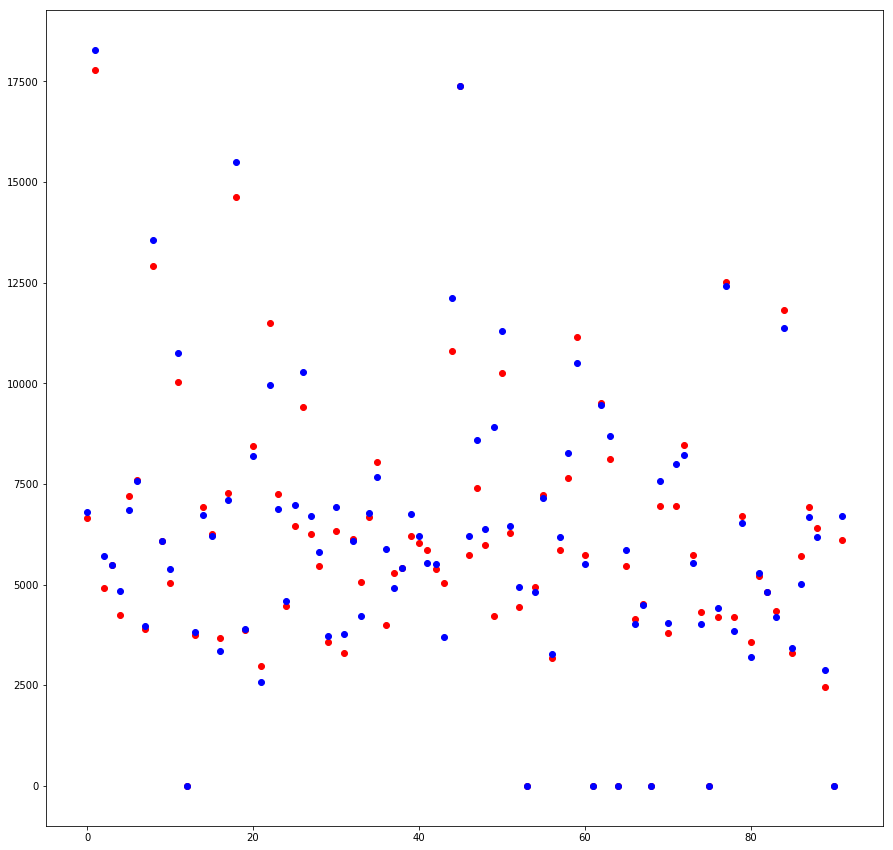

In [178]:
plt.figure(figsize=(15,15))
plt.scatter(range(len(np.expm1(pred_valid)[::1115])), np.expm1(pred_valid)[::1115], color='red')
plt.scatter(range(len(np.expm1(y_valid)[::1115])), np.expm1(y_valid)[::1115], color='blue')

In [179]:
np.mean(np.abs(np.expm1(pred_valid)-np.expm1(y_valid)))

384.92355324676527

In [180]:
np.mean(np.expm1(pred_valid)-np.expm1(y_valid))

-43.94561754199627

#### 校正系数：校正整体偏差

我们的数据平均是要高过真实值的，因此使用校正系数来整体校正偏差是合理的。

In [181]:
results = {}
for actor in [0.990+i/1000. for i in range(50)]:
    results[actor]=rmspe(y_pred=np.expm1(pred_valid)*actor, y_real=np.expm1(y_valid))

print '校正前：'+str(rmspe(np.expm1(pred_valid), np.expm1(y_valid)))
print '校正后：'
print sorted(results.items(),key = lambda x:x[1],reverse = True)[-1]

校正前：0.102096271928
校正后：
(0.99, 0.10108920552208367)


恩恩，效果还不错，下降了0.01，最佳校正系数为0.99。

#### Cross Validation

In [ ]:
print 'XGBoost NModel Cross Validation Start....'
start_time = time.time()
cv_model = xgb.cv(params, train_matrix, num_boost_round, nfold=5, seed=0,  
                  early_stopping_rounds=100)#, feval=rmspe_xgb)
print 'XGBoost NModel Cross Validation End, Time: {:4f} s....'.format(time.time()-start_time)

XGBoost NModel Cross Validation Start....


In [174]:
print 'XGBoost CVModel Valid Start....'
start_time = time.time()
pred_valid = cv_model.predict(xgb.DMatrix(x_valid))
print 'Valid RMSPE:'+str(rmspe(np.expm1(pred_valid), np.expm1(y_valid)))
print 'XGBoost CVModel Valid End, Time: {:4f} s....'.format(time.time()-start_time)

XGBoost Model Valid Start....
Valid RMSPE:0.102096271928
XGBoost Model Valid End, Time: 122.859947 s....


## 结论

## 生成kaggle提交的csv文件

### 预测测试数据并可视化

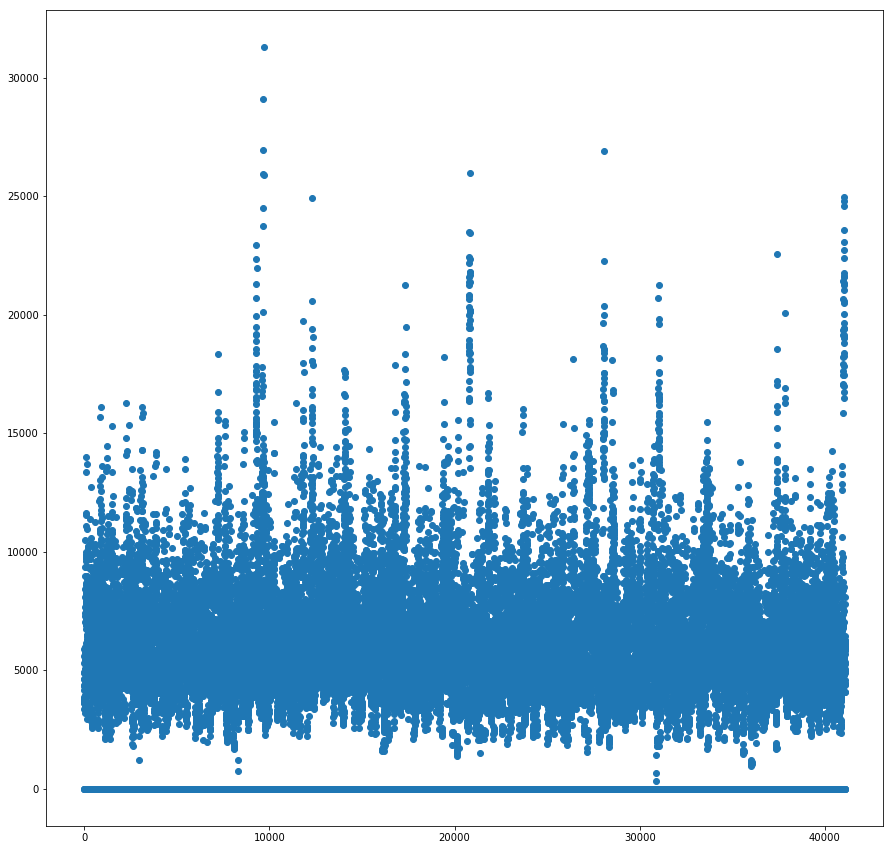

In [243]:
test_id = test_all.Id
test_all.drop(['Id'], axis=1, inplace=True)
pred_test = model.predict(xgb.DMatrix(test_all))
pred_test = pred_test*.99 # 校正系数
plt.figure(figsize=(15,15))
plt.scatter(range(len(pred_test)), np.expm1(pred_test))

### 生成提交csv

In [244]:
pd.DataFrame({'Id':test_id, 'Sales':np.expm1(pred_test)}).to_csv('submission.csv', index=False)

In [245]:
!cat submission.csv

Id,Sales
1,4336.23095703
857,4384.58740234
1713,4897.72753906
2569,5596.50585938
3425,0.024062756449
4281,3776.04125977
5137,3650.1862793
5993,3630.82202148
6849,3620.11108398
7705,3713.41137695
8561,3731.88085938
9417,0.0449797622859
10273,3379.78125
11129,4637.34521484
11985,4618.41162109
12841,4911.66503906
13697,5286.24414062
14553,5877.21533203
15409,0.0757534950972
16265,4152.15283203
17121,3848.39599609
17977,3412.70776367
18833,3379.57495117
19689,3355.6640625
20545,3590.46191406
21401,-0.0581730604172
22257,3575.15356445
23113,4290.47851562
23969,4279.86669922
24825,4357.60205078
25681,4842.93261719
26537,5744.37158203
27393,0.120324529707
28249,3965.92138672
29105,3706.32617188
29961,3595.36303711
30817,3388.35229492
31673,3548.06494141
32529,3687.70874023
33385,-0.0100977960974
34241,3868.11572266
35097,4390.09472656
35953,4407.86962891
36809,4521.08300781
37665,4956.44140625
38521,5770.62207031
39377,0.0890661254525
40233,4243.96923828
2,7025.88085938
858,7302.55322266
1714

23473,5616.86523438
24329,5486.17285156
25185,5560.74267578
26041,5943.84082031
26897,7152.3203125
27753,0.0214454419911
28609,6686.08203125
29465,5010.88574219
30321,4814.72070312
31177,4477.43603516
32033,4604.84521484
32889,4713.48535156
33745,-0.0511940643191
34601,6115.16113281
35457,5489.47070312
36313,5395.12402344
37169,5474.80273438
38025,5863.49121094
38881,7006.15966797
39737,0.114242166281
40593,5457.03515625
362,14727.6298828
1218,15097.1259766
2074,16334.5097656
2930,17700.7832031
3786,0.0594295673072
4642,12445.0214844
5498,11792.8984375
6354,12751.9140625
7210,12659.5253906
8066,13195.4150391
8922,13270.2685547
9778,0.0958571881056
10634,11064.8896484
11490,14174.8447266
12346,15637.2255859
13202,16567.2324219
14058,18341.9980469
14914,21234.375
15770,0.061040032655
16626,13988.4355469
17482,13272.9765625
18338,11969.5576172
19194,12347.90625
20050,12051.4726562
20906,14423.3984375
21762,0.0967669487
22618,13117.5546875
23474,14731.1132812
24330,15881.265625
25186,16150

34084,-0.00955896731466
34940,7857.16845703
35796,9321.99121094
36652,9791.80859375
37508,9339.06835938
38364,11117.0498047
39220,12798.5673828
40076,0.154834076762
40932,8320.05664062
701,11668.8984375
1557,12118.6005859
2413,12715.4550781
3269,13803.0820312
4125,0.00902358442545
4981,11651.7050781
5837,10060.2041016
6693,10241.6328125
7549,10367.4707031
8405,10654.7832031
9261,10461.5351562
10117,0.0517056658864
10973,10248.7460938
11829,11413.9921875
12685,12510.2363281
13541,13286.6816406
14397,13934.6132812
15253,15465.1796875
16109,0.0221793316305
16965,12720.6464844
17821,11103.2001953
18677,10203.0332031
19533,10199.7451172
20389,10235.6953125
21245,11521.1875
22101,0.050990793854
22957,11919.0800781
23813,11379.5888672
24669,12247.296875
25525,12844.71875
26381,13025.859375
27237,14695.1621094
28093,0.0333579853177
28949,12147.9941406
29805,9932.20117188
30661,10140.0332031
31517,10262.9296875
32373,10000.9853516
33229,9958.37207031
34085,-0.0623286105692
34941,11430.703125
35

## kaggle反馈

得分情况：
* private score:0.17406
* publice score:0.16244

![kaggle截图](image/kaggle.png)

## 感悟

1. 跟模型相关的操作、处理相比，特征工程其实更加重要，没有好的特征作为源输入到模型中，结果不会太理想，反过来，如果有很好的特征，那么即便是很简单的模型，表现也会不错。